## Breast Cancer Dataset

Install tensorflow and tensorflow_probability if necessary:

In [1]:
#!pip install tensorflow
#!pip install tensorflow_probability

In [2]:
import utils_deconfounder
from utils_deconfounder import *


Check that it is the correct version of tf (v. 2.5 or at least 2.0 is needed in this project):

In [3]:
!pip show tensorflow
!pip show tensorflow_probability

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/sophieroed/anaconda3/lib/python3.8/site-packages
Requires: keras-nightly, grpcio, termcolor, wheel, gast, astunparse, absl-py, six, flatbuffers, opt-einsum, keras-preprocessing, tensorboard, typing-extensions, numpy, tensorflow-estimator, google-pasta, h5py, protobuf, wrapt
Required-by: 
Name: tensorflow-probability
Version: 0.13.0
Summary: Probabilistic modeling and statistical inference in TensorFlow
Home-page: http://github.com/tensorflow/probability
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /Users/sophieroed/anaconda3/lib/python3.8/site-packages
Requires: numpy, gast, decorator, cloudpickle, dm-tree, six
Required-by: 


Set a random seed:

In [4]:
randseed = 111
print("random seed: ", randseed)
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

random seed:  111


## Data

In [5]:
data = load_breast_cancer()

It is possible to choose some of the features to work with if one has some knowlegde about, which are most relevant as causes; here we have chosen all:

In [6]:
num_fea = 20
df = pd.DataFrame(data["data"][:,:num_fea], columns=data["feature_names"][:num_fea])

In [7]:
df.shape

(569, 20)

In [8]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115


In [9]:
dfy = data["target"]

We note that the outcome variable is binary:

In [10]:
dfy.shape, dfy[:20] 

((569,), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

We will omit the highly correlated causes: "If two causes are highly correlated, a valid substitute confounder will largely inflate the variance of causal estimates downstream." See "a note on overlap" in the paper by Wang and Blei (2019).

We omit these much correlated causes by considering the scatter plots and removing based solely on these plots. The code for the plot is commented out as it takes a while to run it.

From the plot we see that the feature $\texttt{perimeter}$, and $\texttt{area}$ are highly correlated with $\texttt{radius}$ (and each other), moreover, feature $\texttt{worst area}$, and $\texttt{worst smoothness}$ are also highly correlated with $\texttt{radius}$.



In [11]:
#sns.pairplot(df, height=1.5)

In [12]:
fea_cols = df.columns[[(not df.columns[i].endswith("mean perimeter"))
                       and (not df.columns[i].endswith("mean area"))
                       and (not df.columns[i].endswith("worst area"))
                       and (not df.columns[i].endswith("worst smoothness"))
                       for i in range(df.shape[1])
]]

The data ultimately have the following shape and we print the first rows of the dataset:

In [13]:
dfX = pd.DataFrame(df[fea_cols])

print(dfX.shape, dfy.shape)

(569, 18) (569,)


In [14]:
dfX.head()

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
0,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193
1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532
2,19.69,21.25,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571
3,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208
4,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115


## Standerdize data and make train/ validation split

We standardize the data (not required in the deconfounder).

And then we hold out some data for the posterior predictive model check.

In [15]:
X = np.array((dfX - dfX.mean())/dfX.std()) # Standardize

If we whiten the data for the PICA LVM the model does not pass the model check using PPC:

In [16]:

#from scipy import linalg
#
#xc = dfX - np.mean(dfX, axis=0)
#
#print('xc.shape:', xc.shape, '\n')
#
## Calculate covariance matrix
#xcov = np.cov(xc, rowvar=True, bias=True)
#print('Covariance matrix: \n', xcov, '\n')
# 
## Calculate Eigenvalues and Eigenvectors
#w, v = linalg.eig(xcov)
## Note: Use w.real.round(4) to (1) remove 'j' notation to real, (2) round to '4' significant digits
#print("Eigenvalues:\n", w.real.round(4), '\n')
#print("Eigenvectors:\n", v, '\n')
# 
## Calculate inverse square root of Eigenvalues
## Optional: Add '.1e5' to avoid division errors if needed
## Create a diagonal matrix
#diagw = np.diag(1/(w**0.5)) # or np.diag(1/((w+.1e-5)**0.5))
#diagw = diagw.real.round(4) #convert to real and round off
#print("Diagonal matrix for inverse square root of Eigenvalues:\n", diagw, '\n')
# 
## Calculate Rotation (optional)
## Note: To see how data can be rotated
#xrot = np.dot(v, xc)
# 
## Whitening transform using PCA (Principal Component Analysis)
#X = np.dot(np.dot(diagw, v.T), xc)

Train / validation split:

In [17]:
num_datapoints, data_dim = X.shape

holdout_portion = 0.2

n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)

holdout_mask = (sparse.coo_matrix((np.ones(n_holdout),     #The data (ones) in any order
                            (holdout_row, holdout_col)),   # Indices of which rows and columns the data needs to be placed
                            shape = X.shape)).toarray()    # the shape of the entire matrix in which the data needs to be placed and other entries left empty

holdout_subjects = np.unique(holdout_row)
#print(holdout_mask)
holdout_mask = np.minimum(1, holdout_mask)                  # There were some repetitions, which also needs to be one

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

## Fit latent variable model: PPCA

The model is defined and fitted using variational inference and the functions for this is found in the file "ultils_deconfounder.py".

In [18]:
model_ppca, surrogate_posterior_ppca, w_mean_ppca, w_stddv_ppca, z_mean_ppca, z_stddv_ppca, losses_ppca = fit_ppca(x_train = x_train,
                                                                                                                   latent_dim = 3,
                                                                                                                   mask = 1-holdout_mask,
                                                                                                                  stddv_datapoints = 0.5)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


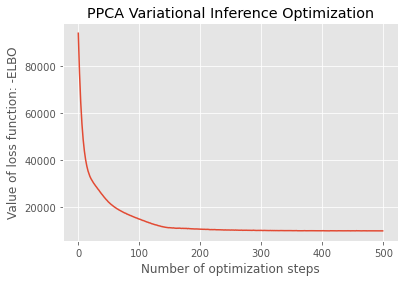

In [19]:
#print("Inferred parameters, W:")
#print(w_mean)
#print("Standard Deviation of inferred parameters, W:")
#print(w_stddv)

plt.plot(losses_ppca)
#plt.ylim(0,200000)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("PPCA Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_ppca)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("PPCA Variational Inference Optimization")
#beingsaved.savefig('ppca_vi_loss_plot.eps', format='eps', dpi=1200)


## Posterior Predictive Checks: PPCA

The fitness of the model is checked and the functions for this is found in the file "ultils_deconfounder.py".

n_rep is the number of replicated datasets we generate and n_eval is the number of samples drawn from Z and W. 

In [20]:
overall_pval_ppca, holdout_subjects, rep_ll_per_zi_ppca, obs_ll_per_zi_ppca = ppc_ppca(x_train = x_train, 
                                                                                       x_vad = x_vad,
                                                                                       mask = holdout_mask,
                                                                                       holdout_row = holdout_row,
                                                                                       model = model_ppca, 
                                                                                       surrogate_posterior = surrogate_posterior_ppca,
                                                                                       w_mean = w_mean_ppca,
                                                                                       w_stddv = w_stddv_ppca,
                                                                                       z_mean = z_mean_ppca,
                                                                                       z_stddv = z_stddv_ppca,
                                                                                       stddv_datapoints = 0.5)

print("Predictive check p-value (PPCA)", overall_pval_ppca)

Predictive check p-value (PPCA) 0.25407871198568877


Predictive check graph for random subject:

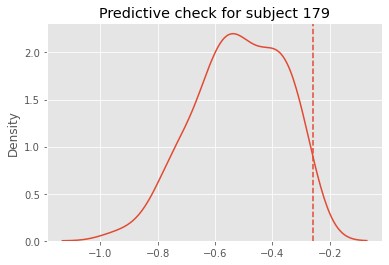

In [21]:
subject_no = npr.choice(holdout_subjects) 
sns.kdeplot(rep_ll_per_zi_ppca[:,subject_no]).set_title("Predictive check for subject "+str(subject_no))
plt.axvline(x=obs_ll_per_zi_ppca[subject_no], linestyle='--')



In [22]:
#beingsaved = plt.figure()
#sns.kdeplot(rep_ll_per_zi_ppca[:,subject_no]).set_title("PPCA: Predictive check for subject "+str(subject_no))
#plt.axvline(x=obs_ll_per_zi_ppca[subject_no], linestyle='--')
#beingsaved.savefig('ppc_random_subject_plot.eps', format='eps', dpi=1200)


## Fit latent variable model: PICA (with Laplacian prior)

The model is defined and fitted using variational inference and the functions for this is found in the file "ultils_deconfounder.py".

In [23]:
model_pica, surrogate_posterior_pica, w_mean_pica, w_stddv_pica, z_mean_pica, z_stddv_pica, losses_pica = fit_pica(x_train = x_train,
                                                                                                                   latent_dim = 3,
                                                                                                                   mask = 1-holdout_mask,
                                                                                                                   stddv_datapoints = 0.5)

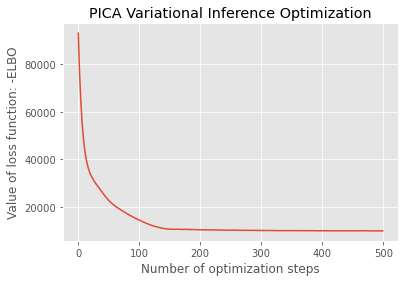

In [24]:
plt.plot(losses_pica)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("PICA Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_pica)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("PICA Variational Inference Optimization")
#beingsaved.savefig('pica_vi_loss_plot.eps', format='eps', dpi=1200)


## Posterior Predictive Checks: PICA

The fitness of the model is checked and the functions for this is found in the file "ultils_deconfounder.py".

n_rep is the number of replicated datasets we generate and n_eval is the number of samples drawn from Z and W. 

In [25]:
overall_pval_pica, holdout_subjects, rep_ll_per_zi_pica, obs_ll_per_zi_pica = ppc_pica(x_train = x_train, 
                                                                                       x_vad = x_vad,
                                                                                       mask = holdout_mask,
                                                                                       holdout_row = holdout_row,
                                                                                       model = model_pica, 
                                                                                       surrogate_posterior = surrogate_posterior_pica,
                                                                                       w_mean = w_mean_pica,
                                                                                       w_stddv = w_stddv_pica,
                                                                                       z_mean = z_mean_pica,
                                                                                       z_stddv = z_stddv_pica,
                                                                                       stddv_datapoints = 0.5)

print("Predictive check p-value (PICA)", overall_pval_pica)

Predictive check p-value (PICA) 0.26432915921288014


Predictive check graph for random subject:

In [26]:
#subject_no = npr.choice(holdout_subjects) 
#sns.kdeplot(rep_ll_per_zi_pica[:,subject_no]).set_title("Predictive check for subject "+str(subject_no))
#plt.axvline(x=obs_ll_per_zi_pica[subject_no], linestyle='--')

## Fit Latent Variable Model: Bayesian GMM

First: Make a class that inherits the attribbutes from tfd.TransformedDistribubtion such that we can e.g. use the method sample from this distribution. 

The `joint_log_prob` function:

Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.

Precision is the inverse covariance, therefore we take the inverse of the precision in order to get the covaraince matrix. I.e. instead of dividing with the covariance, we multiply with the precision. 

arg.max is to find the indices of the maximum values such that we have an estimate of which of the K normal distributions the observation belongs/ is assigned to. Why we take the max, we shall explain in a second.

Ultimately z_post is and $N \times 1$ matrix.

Not sure why we take the log of the mixture probabilities and substract the remaining...
BECAUSE we have

$$\log(\theta_{\text{mean}}) - \sum_{M}\frac{(x_{\text{train}}-\mu_{\text{mean}})^2}{\sigma^2_{\text{mean}}},$$

here the first part is the estimated mixture probabilities, which are minus something when log is taken. The second part is the one we wish to be as small as possible and when substarcting the second part, we wish to find the maximum value - i.e. the one with the smallest second term. The indices (of K possible) hereof are the estimates of the latent variables. 

Explore the bandedness of T by using a cholesky decomposition, where L in LL^T is lower triangular. Therefore, remember that in the Gaussian distribution, we do not use the cholesky lower triangular as scale but the precision inversed en square root...

In [27]:
%%capture 
z_post, mu_post, pi_post, precision_post, sigma_post, acceptance_rate = fit_gmm(x_train = x_train, components = 3);

In [28]:
acceptance_rate

0.656

Graph of three HMC chains samples of the (one out of five) mixture probability, the figure is presented in the project:

In [29]:
#z_post, mu_post, pi_post, precision_post, sigma_post, acceptance_rate, is_accepted, mix_probs1, mix_probs2, mix_probs3 = fit_gmm2(x_train = x_train, components = 5)

In [30]:
#plt.plot(mix_probs1[:,1], color="blue")
#plt.plot(mix_probs2[:,0], color="lightgreen")
#plt.plot(mix_probs3[:,4], color="orange")
#plt.xlabel("Steps")
#plt.ylabel("Mixture probability")
#plt.title("Three HMC chain samples of one of the mixture probabilities")
#plt.show
#
##beingsaved = plt.figure()
##plt.plot(mix_probs1[:,1], color="blue")
##plt.plot(mix_probs2[:,0], color="lightgreen")
##plt.plot(mix_probs3[:,4], color="orange")
##plt.xlabel("Steps")
##plt.ylabel("Mixture probability")
##plt.title("Three HMC chain samples of one mixture probability")
##
##beingsaved.savefig('hmc_chain_plot.eps', format='eps', dpi=1200)



## Posterior Predictive Checks: GMM

In [31]:
overall_pval_gmm = ppc_gmm(x_train = x_train, 
                           x_vad = x_vad,
                           components = 3, 
                           holdout_mask = holdout_mask,
                           z_post = z_post,
                           mu_post = mu_post,
                           pi_post = pi_post,
                           sigma_post = sigma_post,
                           n_rep = 100, 
                           n_eval = 100)

In [32]:
print("Predictive check p-value (GMM)", overall_pval_gmm)

Predictive check p-value (GMM) 0.4122222222222222


## Fit Latent Variable Model: DLGM (with sigmoid activation function)


Define model:

In [33]:
model_dlgm, surrogate_posterior_dlgm, w0_mean_dlgm, w0_stddv_dlgm, z0_mean_dlgm, z0_stddv_dlgm, losses_dlgm = fit_dlgm(x_train = x_train,
                                                                                                                      prior_stddv_datapoints = 1)    

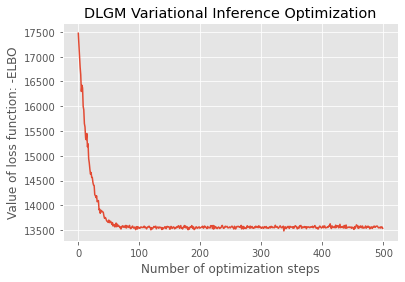

In [34]:
plt.plot(losses_dlgm)
plt.xlabel("Number of optimization steps")
plt.ylabel("Value of loss function: -ELBO")
plt.title("DLGM Variational Inference Optimization")
plt.show()

#beingsaved = plt.figure()
#plt.plot(losses_dlgm)
#plt.xlabel("Number of optimization steps")
#plt.ylabel("Value of loss function: -ELBO")
#plt.title("DLGM Variational Inference Optimization")
#beingsaved.savefig('dlgm_vi_loss_plot.eps', format='eps', dpi=1200)




# Posterior Predictive Checks: DLGM

In [35]:
overall_pval_dlgm, holdout_subjects_dlgm, rep_ll_per_zi_dlgm, obs_ll_per_zi_dlgm = ppc_dlgm(x_train = x_train,
                                                                                            x_vad = x_vad,
                                                                                            mask = holdout_mask,
                                                                                            holdout_row = holdout_row,
                                                                                            model = model_dlgm, 
                                                                                            surrogate_posterior = surrogate_posterior_dlgm,
                                                                                            w0_mean = w0_mean_dlgm,
                                                                                            w0_stddv = w0_stddv_dlgm,
                                                                                            z0_mean = z0_mean_dlgm,
                                                                                            z0_stddv = z0_stddv_dlgm,
                                                                                           stddv_datapoints = 1)

print("Predictive check p-value (DLGM)", overall_pval_dlgm)

Predictive check p-value (DLGM) 0.3987656529516995


## Fit Latent Variable Model: PMF (omitted because it did not pass the model check)

In [36]:
#model_pmf, surrogate_posterior_pmf, w_conc_pmf, w_rate_pmf, z_conc_pmf, z_rate_pmf, losses_pmf = fit_pmf(x_train = x_train, latent_dim = 3, mask = 1-holdout_mask, gamma_prior = 0.1)

In [37]:
#overall_pval_pmf, holdout_subjects_pmf, rep_ll_per_zi_pmf, obs_ll_per_zi_pmf = ppc_dlgm(x_train = x_train,
#                                                                                            x_vad = x_vad,
#                                                                                            mask = holdout_mask,
#                                                                                            holdout_row = holdout_row,
#                                                                                            model = model_pmf, 
#                                                                                            surrogate_posterior = surrogate_posterior_pmf,
#                                                                                            w_mean = w_conc_pmf,
#                                                                                            w_stddv = w_rate_pmf,
#                                                                                            z_mean = z_conc_pmf,
#                                                                                            z_stddv = z_rate_pmf)
#
#print("Predictive check p-value (PMF)", overall_pval_pmf)

## Causal inference with estimated latent variables as substitue confounders

We fit a logistic regression as the outcome model as a consequence of binary outcome variables. I.e. the target is $Y_i$ for $i = 1,...,N$ and the regressors are the multiple causes used in the LVMs, $X_i$ for $i = 1,...,N$. Lastly, we correct for the estimated substitue confounder, $Z_i$ for $i = 1,...,N$, by including it into the regressors. Note that we could take a finite set of the causes in order to ensure positivity in causal inference and therefore, we could omit one of the causes used in the LVMs. However, we shall not do so since the number of causes are already finite. 

In [38]:
#dfX_causal_inf = dfX.drop(["area error", "perimeter error"], axis = 1)

In [39]:
#X_causal_inf = np.array((dfX_causal_inf - dfX_causal_inf.mean())/dfX_causal_inf.std()) # Standardize

In [40]:
#data_dim_causal_inf = X_causal_inf.shape[1]

## PPCA:

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [41]:
dcf_ppca_result, no_dcf_result, res_ppca, pred_report_ppca, dcflogit_roc_auc_ppca, dcffpr_ppca, dcftpr_ppca, nodcflogit_roc_auc, nodcffpr, nodcftpr = fit_causal_model(X = X, 
                                                                                                                                                                       dfy = dfy,
                                                                                                                                                                       dfX_causal_inf = dfX,
                                                                                                                                                                       z_mean = z_mean_ppca,
                                                                                                                                                                       data_dim_causal_inf = data_dim)     


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06430406208210812
            Iterations: 218
            Function evaluations: 219
            Gradient evaluations: 218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07160532618881699
            Iterations: 187
            Function evaluations: 187
            Gradient evaluations: 187


In [42]:
print(dcf_ppca_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.9018
Time:                        10:26:40   Log-Likelihood:                -29.258
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                2.146e-100
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1175      1.322     -1.602      0.109      -4.708       0.473
x1            -1.2282      2.232     -0.550      0.582      -5.604       3.147
x2            -3.6136      1.198     -3.017      0.0

In [43]:
print(pred_report_ppca)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        47
           1       0.95      0.90      0.92        67

    accuracy                           0.91       114
   macro avg       0.91      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



In [44]:
print(no_dcf_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                           18
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8907
Time:                        10:26:40   Log-Likelihood:                -32.580
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.417e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0472      1.144     -1.790      0.074      -4.289       0.195
x1            -2.2202      1.883     -1.179      0.238      -5.912       1.471
x2            -2.1756      0.592     -3.678      0.0

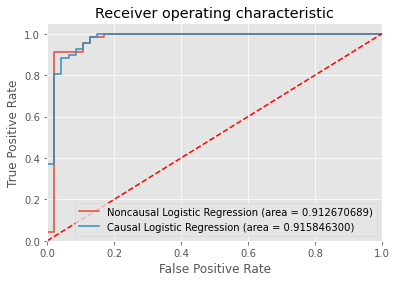

In [45]:
plt.figure()
plt.plot(nodcffpr, nodcftpr, label='Noncausal Logistic Regression (area = %0.9f)' % nodcflogit_roc_auc)
plt.plot(dcffpr_ppca, dcftpr_ppca, label='Causal Logistic Regression (area = %0.9f)' % dcflogit_roc_auc_ppca)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [46]:
res_ppca.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
mean smoothness,-0.506864,0.150676,0.657540,False,False,1.569865,0.396175
concave points error,-0.150028,0.660059,0.810087,False,False,0.590689,0.293604
texture error,-0.105037,0.166377,0.271414,False,False,-1.120864,0.691152
radius error,-0.097723,0.831229,0.928952,False,False,-1.214136,0.482711
perimeter error,-0.061583,0.690628,0.752211,False,False,1.59632,1.123717
mean compactness,-0.019667,0.01805,0.037718,True,True,7.155125,5.215764
mean concave points,-0.019526,0.308758,0.328284,False,False,-3.542579,-3.111401
compactness error,-0.010191,0.033955,0.044147,True,True,-3.619769,-2.950415
concavity error,0.001758,0.25692,0.255162,False,False,3.312124,3.097615
mean texture,0.002321,0.002556,0.000235,True,True,-3.613563,-2.175580


## PICA:

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [47]:
dcf_pica_result, no_dcf_result, res_pica, pred_report_pica, dcflogit_roc_auc_pica, dcffpr_pica, dcftpr_pica, nodcflogit_roc_auc, nodcffpr, nodcftpr = fit_causal_model(X = X, 
                                                                                                                                                                       dfy = dfy,
                                                                                                                                                                       dfX_causal_inf = dfX,
                                                                                                                                                                       z_mean = z_mean_pica,
                                                                                                                                                                       data_dim_causal_inf = data_dim)     


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06587455222293799
            Iterations: 218
            Function evaluations: 218
            Gradient evaluations: 218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07160532618881699
            Iterations: 187
            Function evaluations: 187
            Gradient evaluations: 187


In [48]:
print(dcf_pica_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8994
Time:                        10:26:41   Log-Likelihood:                -29.973
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                4.275e-100
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2342      1.289     -1.733      0.083      -4.762       0.293
x1            -0.8623      2.119     -0.407      0.684      -5.015       3.290
x2            -2.6750      0.937     -2.855      0.0

In [49]:
print(pred_report_pica)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        47
           1       0.92      0.90      0.91        67

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.90      0.89      0.90       114



In [50]:
print(no_dcf_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                           18
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8907
Time:                        10:26:41   Log-Likelihood:                -32.580
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.417e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0472      1.144     -1.790      0.074      -4.289       0.195
x1            -2.2202      1.883     -1.179      0.238      -5.912       1.471
x2            -2.1756      0.592     -3.678      0.0

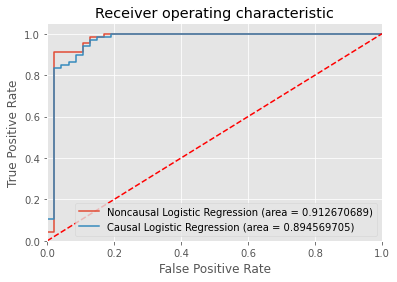

In [51]:
plt.figure()
plt.plot(nodcffpr, nodcftpr, label='Noncausal Logistic Regression (area = %0.9f)' % nodcflogit_roc_auc)
plt.plot(dcffpr_pica, dcftpr_pica, label='Causal Logistic Regression (area = %0.9f)' % dcflogit_roc_auc_pica)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [52]:
res_pica.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
mean smoothness,-0.360015,0.297525,0.657540,False,False,1.095524,0.396175
radius error,-0.093901,0.835051,0.928952,False,False,-1.131624,0.482711
concave points error,-0.093063,0.717023,0.810087,False,False,0.484738,0.293604
perimeter error,-0.08322,0.668991,0.752211,False,False,1.721737,1.123717
mean compactness,-0.014646,0.023071,0.037718,True,True,6.769458,5.215764
texture error,-0.00618,0.265234,0.271414,False,False,-1.149959,0.691152
compactness error,-0.005741,0.038406,0.044147,True,True,-3.302505,-2.950415
concavity error,-0.001064,0.254098,0.255162,False,False,3.41381,3.097615
mean fractal dimension,-0.00083,0.006931,0.007761,True,True,-5.480156,-4.107518
mean texture,0.004062,0.004297,0.000235,True,True,-2.675038,-2.175580


## DLGM:

We approximate with the inferred mean the random variables, $Z$, that are substitue confounders and augment the regressors into a gathered dataset.

In [53]:
dcf_dlgm_result, no_dcf_result, res_dlgm, pred_report_dlgm, dcflogit_roc_auc_dlgm, dcffpr_dlgm, dcftpr_dlgm, nodcflogit_roc_auc, nodcffpr, nodcftpr = fit_causal_model(X = X, 
                                                                                                                                                                       dfy = dfy,
                                                                                                                                                                       dfX_causal_inf = dfX,
                                                                                                                                                                       z_mean = z0_mean_dlgm,
                                                                                                                                                                       data_dim_causal_inf = data_dim)     


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06379689795744066
            Iterations: 237
            Function evaluations: 238
            Gradient evaluations: 237
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07160532618881699
            Iterations: 187
            Function evaluations: 187
            Gradient evaluations: 187


In [54]:
print(dcf_dlgm_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      429
Method:                           MLE   Df Model:                           25
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.9026
Time:                        10:26:42   Log-Likelihood:                -29.028
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 1.037e-97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9037      1.241     -2.341      0.019      -5.335      -0.472
x1            -1.4555      2.195     -0.663      0.507      -5.758       2.847
x2            -2.2806      0.663     -3.439      0.0

In [55]:
print(pred_report_dlgm)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        47
           1       0.94      0.93      0.93        67

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



In [56]:
print(no_dcf_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                           18
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8907
Time:                        10:26:42   Log-Likelihood:                -32.580
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.417e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0472      1.144     -1.790      0.074      -4.289       0.195
x1            -2.2202      1.883     -1.179      0.238      -5.912       1.471
x2            -2.1756      0.592     -3.678      0.0

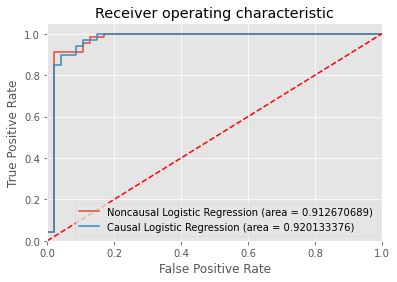

In [57]:
plt.figure()
plt.plot(nodcffpr, nodcftpr, label='Noncausal Logistic Regression (area = %0.9f)' % nodcflogit_roc_auc)
plt.plot(dcffpr_dlgm, dcftpr_dlgm, label='Causal Logistic Regression (area = %0.9f)' % dcflogit_roc_auc_dlgm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [58]:
res_dlgm.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
radius error,-0.509061,0.419891,0.928952,False,False,5.355524,0.482711
concave points error,-0.204399,0.605688,0.810087,False,False,0.684608,0.293604
area error,-0.114908,0.043742,0.158649,True,False,-20.272151,-11.816276
mean smoothness,-0.109479,0.548061,0.657540,False,False,0.648525,0.396175
symmetry error,-0.095843,0.079543,0.175386,False,False,1.427436,1.086305
concavity error,-0.087346,0.167815,0.255162,False,False,3.987449,3.097615
intercept,-0.05425,0.019254,0.073504,True,False,-2.903677,-2.047201
mean concavity,-0.025424,0.01507,0.040493,True,True,-10.54839,-8.109473
mean concave points,-0.014994,0.31329,0.328284,False,False,-3.359214,-3.111401
mean compactness,-0.014234,0.023484,0.037718,True,True,6.92034,5.215764


## GMM:



In [59]:
dcf_gmm_result, no_dcf_result, res_gmm, pred_report_gmm, dcflogit_roc_auc_gmm, dcffpr_gmm, dcftpr_gmm, nodcflogit_roc_auc, nodcffpr, nodcftpr = fit_causal_model(X = X, 
                                                                                                                                                                 dfy = dfy,
                                                                                                                                                                 dfX_causal_inf = dfX,
                                                                                                                                                                 z_mean = z_post,
                                                                                                                                                                 data_dim_causal_inf = data_dim)     


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07046600405520942
            Iterations: 192
            Function evaluations: 192
            Gradient evaluations: 192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07160532618881699
            Iterations: 187
            Function evaluations: 187
            Gradient evaluations: 187


In [60]:
print(dcf_gmm_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      435
Method:                           MLE   Df Model:                           19
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8924
Time:                        10:26:42   Log-Likelihood:                -32.062
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                1.141e-100
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6727      1.726     -0.390      0.697      -4.055       2.709
x1            -1.9887      1.881     -1.058      0.290      -5.674       1.697
x2            -2.1366      0.596     -3.583      0.0

In [61]:
print(pred_report_gmm)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        47
           1       0.94      0.93      0.93        67

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



In [62]:
print(no_dcf_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                           18
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8907
Time:                        10:26:42   Log-Likelihood:                -32.580
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.417e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0472      1.144     -1.790      0.074      -4.289       0.195
x1            -2.2202      1.883     -1.179      0.238      -5.912       1.471
x2            -2.1756      0.592     -3.678      0.0

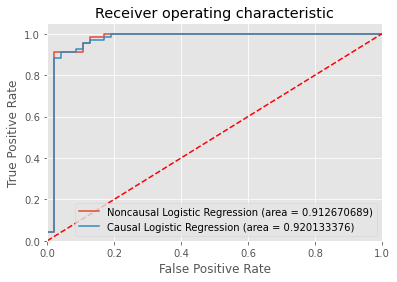

In [63]:
plt.figure()
plt.plot(nodcffpr, nodcftpr, label='Noncausal Logistic Regression (area = %0.9f)' % nodcflogit_roc_auc)
plt.plot(dcffpr_gmm, dcftpr_gmm, label='Causal Logistic Regression (area = %0.9f)' % dcflogit_roc_auc_gmm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [64]:
res_gmm.sort_values("pval_diff", ascending=True)[["pval_diff", "causal_pval", "noncausal_pval", "causal_sig", "noncausal_sig", "causal_mean", "noncausal_mean"]]

,pval_diff,causal_pval,noncausal_pval,causal_sig,noncausal_sig,causal_mean,noncausal_mean
smoothness error,-0.069034,0.130917,0.199951,False,False,1.559814,1.135549
perimeter error,-0.060805,0.691406,0.752211,False,False,1.395882,1.123717
symmetry error,-0.037315,0.138071,0.175386,False,False,1.282842,1.086305
mean concave points,-0.034534,0.29375,0.328284,False,False,-3.320309,-3.111401
concave points error,-0.020675,0.789412,0.810087,False,False,0.337031,0.293604
mean texture,0.000104,0.000339,0.000235,True,True,-2.136627,-2.175580
mean symmetry,0.000506,0.008593,0.008088,True,True,-1.901082,-1.850057
compactness error,0.00128,0.045427,0.044147,True,True,-3.054845,-2.950415
radius error,0.008977,0.937928,0.928952,False,False,-0.423915,0.482711
concavity error,0.015819,0.27098,0.255162,False,False,3.047262,3.097615


## Adding the causes one-by-one 

Logistic regression with substitue confounders:

In [65]:
for i in range(X.shape[1]):
    print(i, "causes included")

    z_hat_obo = z_mean_ppca
    X_aug_obo = np.column_stack([X[:,:i], z_hat_obo])
    
    X_train_obo, X_test_obo, y_train_obo, y_test_obo = train_test_split(X_aug_obo, 
                                                                            dfy, 
                                                                            test_size=0.2, 
                                                                            random_state=0)
    
    dcf_obo_X_train = sm.add_constant(X_train_obo)
    dcf_obo_logit_model = sm.Logit(y_train_obo, dcf_obo_X_train)
    dcf_obo_result = dcf_obo_logit_model.fit_regularized(maxiter=5000)
    
    print(dcf_obo_result.summary())

0 causes included
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1587459724848639
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      451
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.7576
Time:                        10:26:42   Log-Likelihood:                -72.229
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 1.528e-97
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            8
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8330
Time:                        10:26:42   Log-Likelihood:                -49.753
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                4.020e-102
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6743      0.301      2.242      0.025       0.085       1.264
x1            -1.3627      0.990     -1.376      0.169      -3.304       0.579
x2            -2.1287      0.530     -4.017      0.0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08794528323374518
            Iterations: 110
            Function evaluations: 110
            Gradient evaluations: 110
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      441
Method:                           MLE   Df Model:                           13
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8657
Time:                        10:26:43   Log-Likelihood:                -40.015
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                5.987e-102
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08046304183953651
            Iterations: 162
            Function evaluations: 162
            Gradient evaluations: 162
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                           17
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8771
Time:                        10:26:43   Log-Likelihood:                -36.611
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.019e-100
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07428573009707791
            Iterations: 201
            Function evaluations: 201
            Gradient evaluations: 201
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                           20
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8866
Time:                        10:26:43   Log-Likelihood:                -33.800
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 3.286e-99
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

Classical logistic regression:

In [66]:
for i in range(X.shape[1]):
    print(i, "causes included")
    X_aug = np.column_stack([X[:,:i]])
    X_train, X_test, y_train, y_test = train_test_split(X_aug, dfy, test_size=0.2, random_state=0)
    dcfX_train = sm.add_constant(X_train)
    dcflogit_model = sm.Logit(y_train, dcfX_train)
    dcfresult = dcflogit_model.fit_regularized(maxiter=5000)
    print(dcfresult.summary())  

0 causes included
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6549205599225008
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            0
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:               7.357e-13
Time:                        10:26:43   Log-Likelihood:                -297.99
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      448
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.7887
Time:                        10:26:43   Log-Likelihood:                -62.960
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 2.361e-98
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7376      0.248      2.975      0.003       0.252       1.223
x1            -3.5398      0.807     -4.384      0.000      -5.122      -1.957
x2            -1.6821      0.302     -5.563      0.0

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                           11
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8172
Time:                        10:26:44   Log-Likelihood:                -54.478
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                 1.876e-97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5894      0.323      1.825      0.068      -0.044       1.222
x1            -2.4741      0.995     -2.487      0.013      -4.424      -0.524
x2            -2.3725      0.407     -5.823      0.0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08364615218498053
            Iterations: 147
            Function evaluations: 147
            Gradient evaluations: 147
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  455
Model:                          Logit   Df Residuals:                      439
Method:                           MLE   Df Model:                           15
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.8723
Time:                        10:26:44   Log-Likelihood:                -38.059
converged:                       True   LL-Null:                       -297.99
Covariance Type:            nonrobust   LLR p-value:                3.542e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------